In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np

In [2]:
CUE_ON_T = 1.0
SAMPLE_ON_T = SACCADE_ON_TIME = 3.0
MNM_END_TIME = 3.0
SUBREGIONS = {'Mid-Dorsal': 'MD', 'Posterior-Ventral': 'PV',
              'Anterior-Dorsal': 'AD', 'Posterior-Dorsal': 'PD', 'Anterior-Ventral': 'AV'}

def mat_to_df(dg, monkey, area, num_stimuli=1, numeric_cell=False, ):
    rows = []
    cells = []
    for c in range(dg.shape[0]):
        c_num = str(c + 1).zfill(3)
        cell_name = f'{monkey}-{area}-{c_num}'
        # cells.append([c + 1 if numeric_cell else cell_name, monkey, area])
        for p in range(dg.shape[1]):
            feature_names = dg[c][p][0].dtype.names
            for t in range(dg[c, p].shape[1]):
                cue_on_t = dg[c, p][0, t]['Cue_onT'][0][0]
                ts = dg[c, p][0, t]['TS'].flatten()
                if num_stimuli == 1:
                    ts = ts - cue_on_t + CUE_ON_T
                    ts = np.array([t for t in ts if t >= 0 and t <=
                                  SACCADE_ON_TIME + 1.0], dtype=np.float32)
                    if (len(ts) > 0):
                        rows.append([cell_name, p, t, ts])  # , cue_on_t])
                else:
                    sample_on_t = dg[c, p][0, t]['Sample_onT'][0][0]
                    ts2 = np.array([SAMPLE_ON_T + t - sample_on_t for t in ts if t >
                                   sample_on_t and t <= sample_on_t + MNM_END_TIME], dtype=np.float32)
                    ts = np.array([t - cue_on_t + CUE_ON_T for t in ts if t >= cue_on_t -
                                  CUE_ON_T and t <= cue_on_t + SAMPLE_ON_T - CUE_ON_T], dtype=np.float32)
                    ts = np.concatenate((ts, ts2))
                    try:
                        ismatch = dg[c, p][0, t]['IsMatch'][0][0]
                        if len(ts) > 0:
                            rows.append([c + 1, p, t, ts, ismatch])
                    except:
                        pass
 
    df = pd.DataFrame(rows, columns=[
                      'cell', 'position', 'trial', 'ts'] + ([] if num_stimuli == 1 else ['ismatch']))
    # df = df.set_index(['cell', 'position', 'trial'])
    # , pd.DataFrame(cells, columns=['cell', 'monkey', 'area']).set_index('cell')
    return df

In [3]:
def get_cells(df, style='monkey-area'):
    cells = df.cell.unique()
    cells = pd.DataFrame(cells, columns=['cell'])
    cells['monkey'] = cells.cell.apply(lambda x: x.split('-')[0])
    cells['area'] = cells.cell.apply(lambda x: x.split('-')[1])
    if 'subregion' in style:
        cells['subregion'] = cells.cell.apply(lambda x: x.split('-')[2])
    if 'phase' in style:
        cells['phase'] = cells.cell.apply(lambda x: x.split('-')[3])
    cells = cells.set_index('cell')
    return cells


In [4]:
def load_mnm_spatial():
    asd_mat = loadmat(
        '../../../data/MNM_original_data/all_spatial_data.mat')['all_spatial_data']
    asi_mat = loadmat(
        '../../../data/MNM_original_data/all_spatial_info.mat')['all_spatial_info']

    asd_mat = asd_mat[:, :8]
    asi_mat = asi_mat[:, [0, 3, 4]]
    extract = np.vectorize(lambda x: x[0])
    asi_mat = extract(asi_mat)

    asi_df = pd.DataFrame(asi_mat, columns=['monkey', 'phase', 'subregion'])
    asi_df.monkey = asi_df.monkey.apply(lambda x: x[0:3].upper())
    asi_df.subregion = asi_df.subregion.apply(lambda x: SUBREGIONS[x].upper())

    asd_df = mat_to_df(asd_mat, '<REPLACE>', 'PFC',
                        num_stimuli=2, numeric_cell=True)

    df = pd.merge(asd_df, asi_df, left_on='cell', right_index=True)
    df['cell'] = df.apply(lambda r: '-'.join([r.monkey, 'PFC',
                          str(r.subregion), r.phase, str(r.cell)]), axis=1)
    cells = get_cells(df, style='monkey-area-subregion-phase')
    df = df.drop(columns=['monkey', 'subregion', 'phase'])

    return {'raw_df': df.set_index(['cell', 'position', 'trial']), 'cells': cells}

In [5]:
df_dict = load_mnm_spatial()

In [6]:
raw_df = pd.DataFrame(df_dict['raw_df'])

In [7]:
cells = pd.DataFrame(df_dict['cells'])

In [8]:
cells.sample(3)

,monkey,area,subregion,phase
cell,,,,
NIN-PFC-AV-POST-3002,NIN,PFC,AV,POST
ELV-PFC-MD-PRE-844,ELV,PFC,MD,PRE
BEN-PFC-PV-PRE-1413,BEN,PFC,PV,PRE


In [9]:
cells.columns

Index(['monkey', 'area', 'subregion', 'phase'], dtype='object')

In [8]:
# Resetting the index to move 'cell', 'position', and 'trial' back to columns
raw_df = raw_df.reset_index()

# Verify the change by printing the columns
# raw_df.sample(10)

In [11]:
raw_df.columns

Index(['cell', 'position', 'trial', 'ts', 'ismatch'], dtype='object')

In [9]:
df = pd.merge(raw_df, cells, on='cell', how='inner')
df.sample(3)

,cell,position,trial,ts,ismatch,monkey,area,subregion,phase
97857,ELV-PFC-MD-PRE-785,6,5,"[0.367625, 0.521225, 0.58105, 0.633125, 0.9059...",1,ELV,PFC,MD,PRE
294658,ELV-PFC-MD-POST-2659,6,4,"[0.068025, 1.0167, 1.072025, 1.11235, 1.273125...",1,ELV,PFC,MD,POST
12276,MAN-PFC-AD-PRE-103,6,12,"[0.340975, 0.4326, 0.517325, 0.547025, 0.57562...",0,MAN,PFC,AD,PRE


In [10]:
lengths = df.ts.apply(lambda x: len(x))
# lengths.value_counts()

In [11]:
filtered_df = df
filtered_df['ts_length'] = filtered_df['ts'].apply(len)
average_ts_length = filtered_df.groupby('cell')['ts_length'].mean().reset_index()
sum_ts_length = filtered_df.groupby('cell')['ts_length'].sum().reset_index()
use_cell = average_ts_length[(average_ts_length.ts_length >= 100) & (sum_ts_length.ts_length >= 500)].cell

In [12]:
filtered_df = filtered_df[filtered_df['cell'].isin(use_cell)]
filtered_df.shape

(12980, 10)

In [17]:
12980/20

649.0

In [13]:
pre_df = filtered_df[filtered_df.phase == "PRE"]
post_df = filtered_df[filtered_df.phase == "POST"]
pre_df.shape, post_df.shape

((6497, 10), (6483, 10))

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def get_cell_df(df, cell_name, position):
    return df[(df.cell == cell_name) & (df.position == position) & (df.ismatch == 0)], df[(df.cell == cell_name) & (df.position == position) & (df.ismatch == 1)]

def proc_ts(x):
    rsl = [0] * 60
    for i in x:
        idx = int(i*10) - 1
        rsl[idx] += 1
    
    return rsl

def sum_array(df):
    tss = np.array(df.ts.apply(lambda x: proc_ts(x)).tolist())
    return np.sum(tss, axis=0)

def plotting(df, cell_name):
    fig, axs = plt.subplots(3, 3, figsize=(16, 10))

    i = 0
    for position in range(0, 5, 2):
        cell_df_m, cell_df_n = get_cell_df(df, cell_name, position)
        match_sum, non_sum = sum_array(cell_df_m), sum_array(cell_df_n)
        axs[i, 0].plot(match_sum)
        axs[i, 0].set_title(f"{cell_name}, pos {position}, MATCH")
        axs[i, 0].set_ylabel('Discharge rate (sp/0.1s)')
        axs[i, 0].set_xlabel("Time (0.1s)")
        axs[i, 0].axvspan(10, 15, color='gray', alpha=0.5)
        axs[i, 0].axvspan(30, 35, color='gray', alpha=0.5)
        axs[i, 1].plot(non_sum)
        axs[i, 1].set_title(f"{cell_name}, pos {position}, NON-MATCH")
        axs[i, 1].set_ylabel('Discharge rate (sp/0.1s)')
        axs[i, 1].set_xlabel("Time (0.1s)")
        axs[i, 1].axvspan(10, 15, color='gray', alpha=0.5)
        axs[i, 1].axvspan(30, 35, color='gray', alpha=0.5)
        mean, std = np.mean(match_sum), np.std(match_sum)
        gaussian_curve = norm.pdf(np.linspace(0, 60, 60), mean, std)
        axs[i, 2].plot(gaussian_curve, label='match')
        mean, std = np.mean(non_sum), np.std(non_sum)
        gaussian_curve = norm.pdf(np.linspace(0, 60, 60), mean, std)
        axs[i, 2].plot(gaussian_curve, label="non-match")
        axs[i, 2].set_title(f"{cell_name}, pos {position}, GAUSSIAN CURVE")
        axs[i, 2].set_ylabel('Discharge rate (sp/0.1s)')
        axs[i, 2].set_xlabel("Time (0.1s)")
        axs[i, 2].legend()

        i += 1

    plt.tight_layout()
    plt.show()

In [63]:
cell_show = pre_df.sample(3).cell
cell_show

68890      ELV-PFC-MD-PRE-571
133185    SCR-PFC-MD-PRE-1054
151063    SCR-PFC-PD-PRE-1227
Name: cell, dtype: object

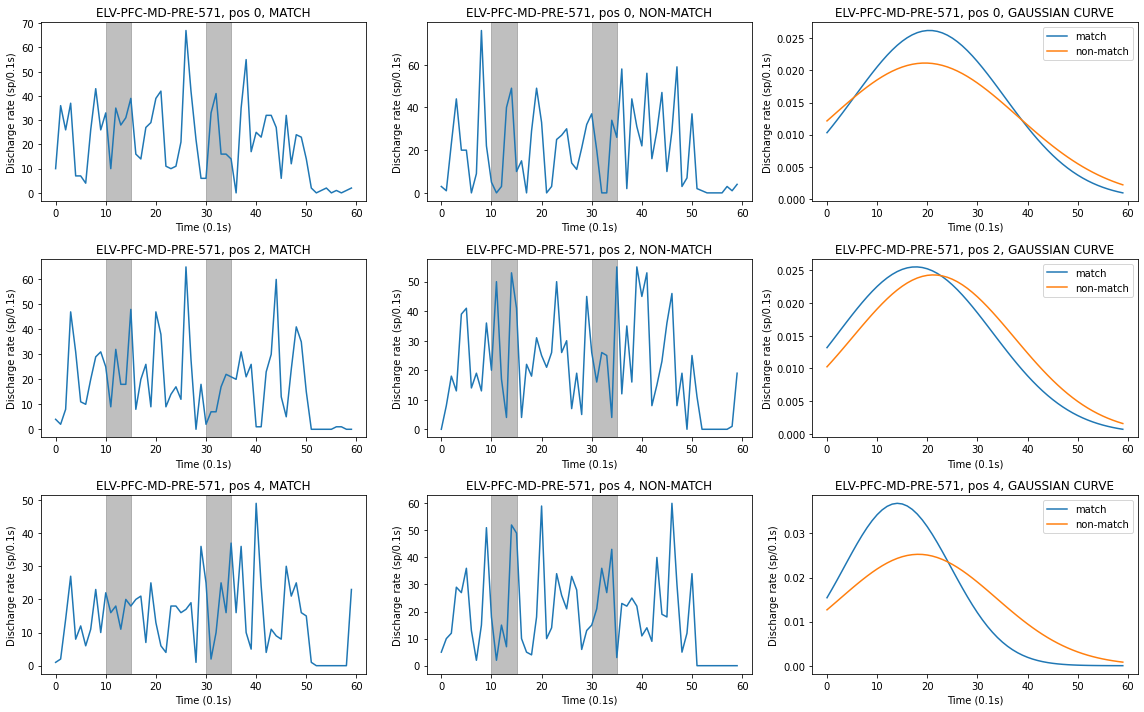

In [93]:
cell_name = "ELV-PFC-MD-PRE-571"
plotting(pre_df, cell_name)

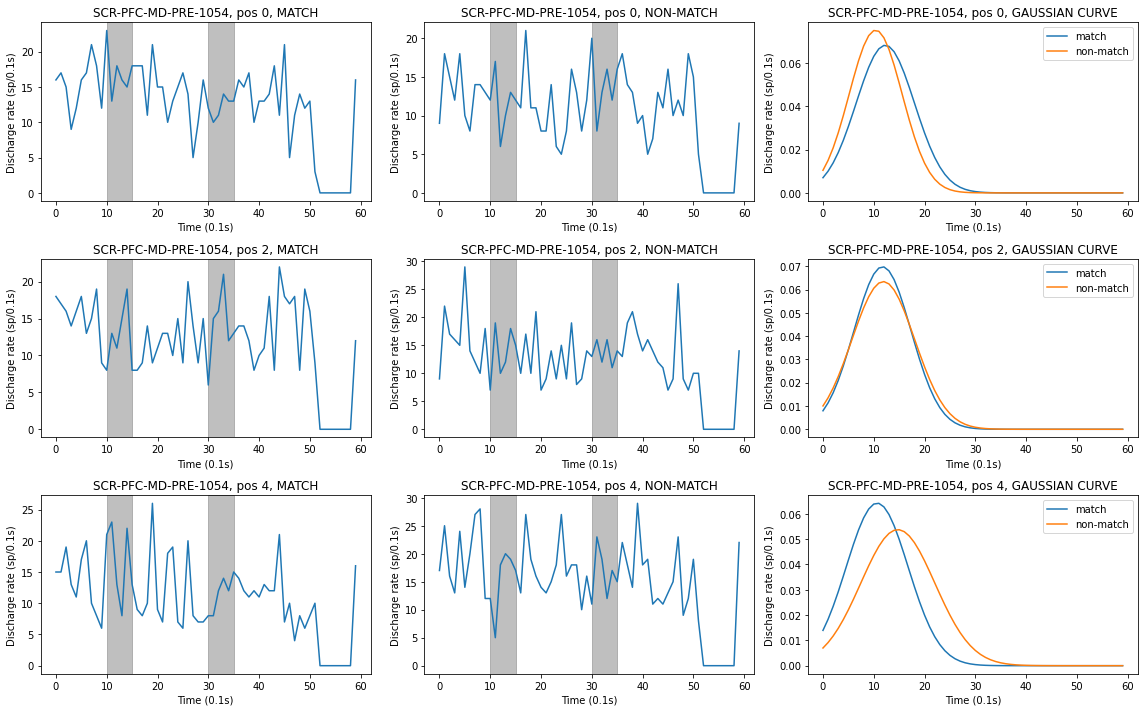

In [94]:
cell_name = "SCR-PFC-MD-PRE-1054"
plotting(pre_df, cell_name)

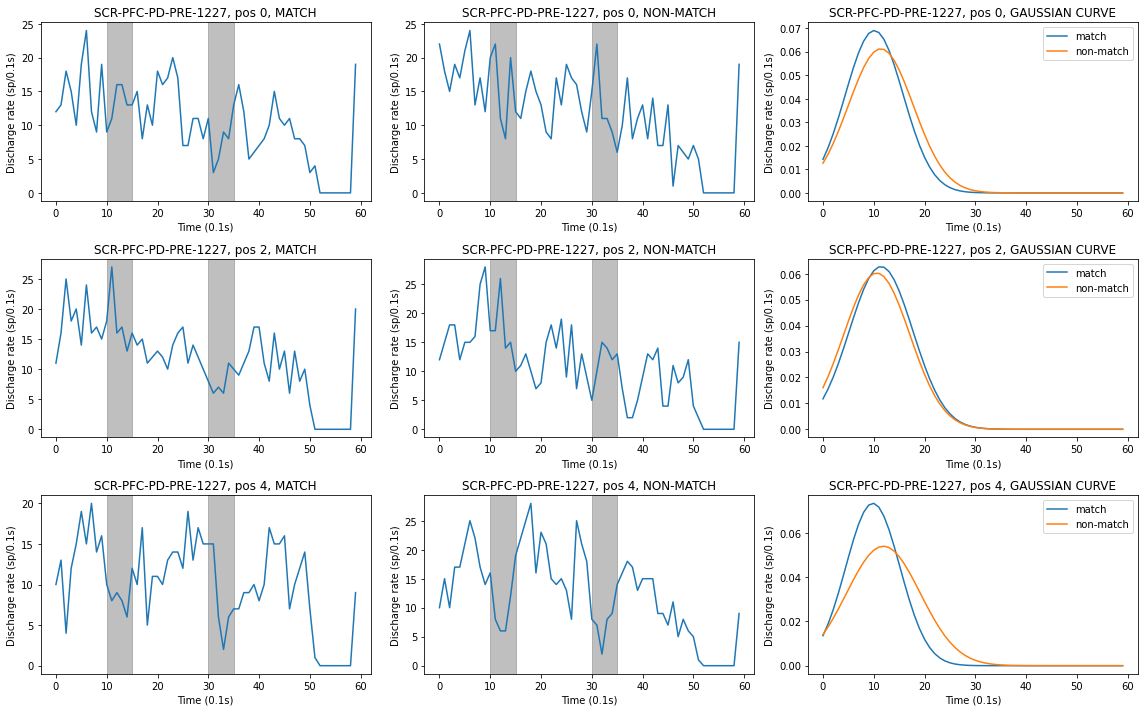

In [95]:
cell_name = "SCR-PFC-PD-PRE-1227"
plotting(pre_df, cell_name)

In [15]:
cell_show = post_df.sample(3).cell
cell_show

303609    ELV-PFC-PV-POST-2763
332954    NIN-PFC-AD-POST-3020
203929    ADR-PFC-MD-POST-1761
Name: cell, dtype: object

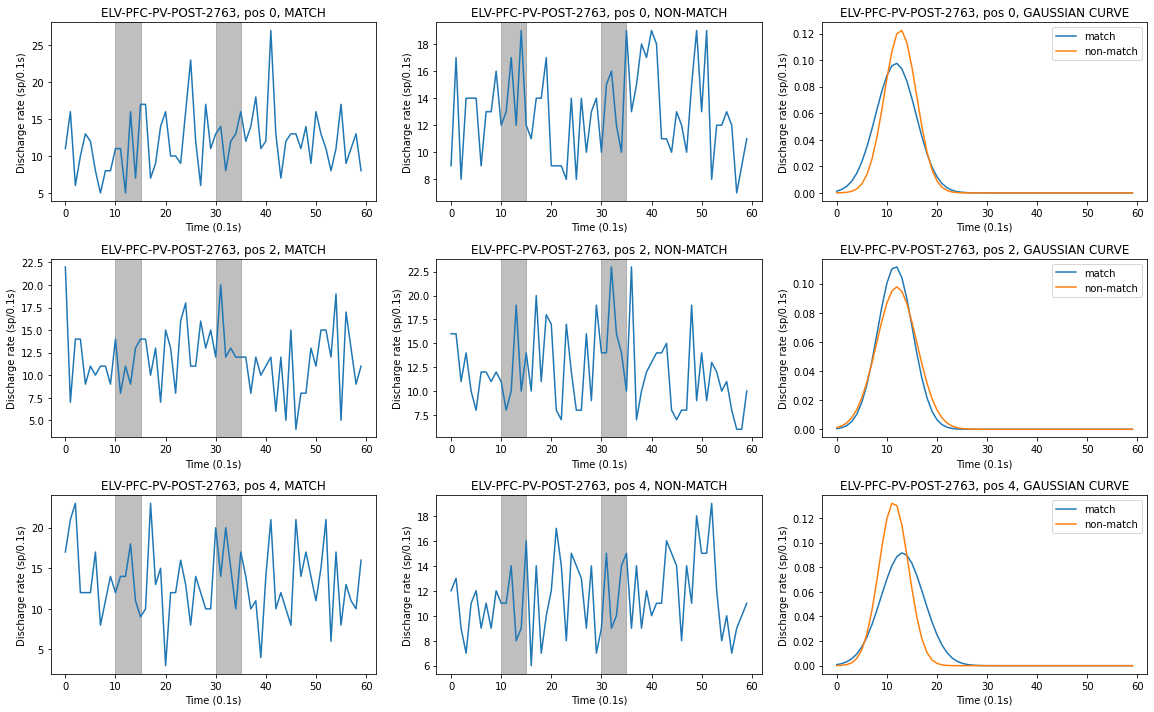

In [96]:
cell_name = "ELV-PFC-PV-POST-2763"
plotting(post_df, cell_name)

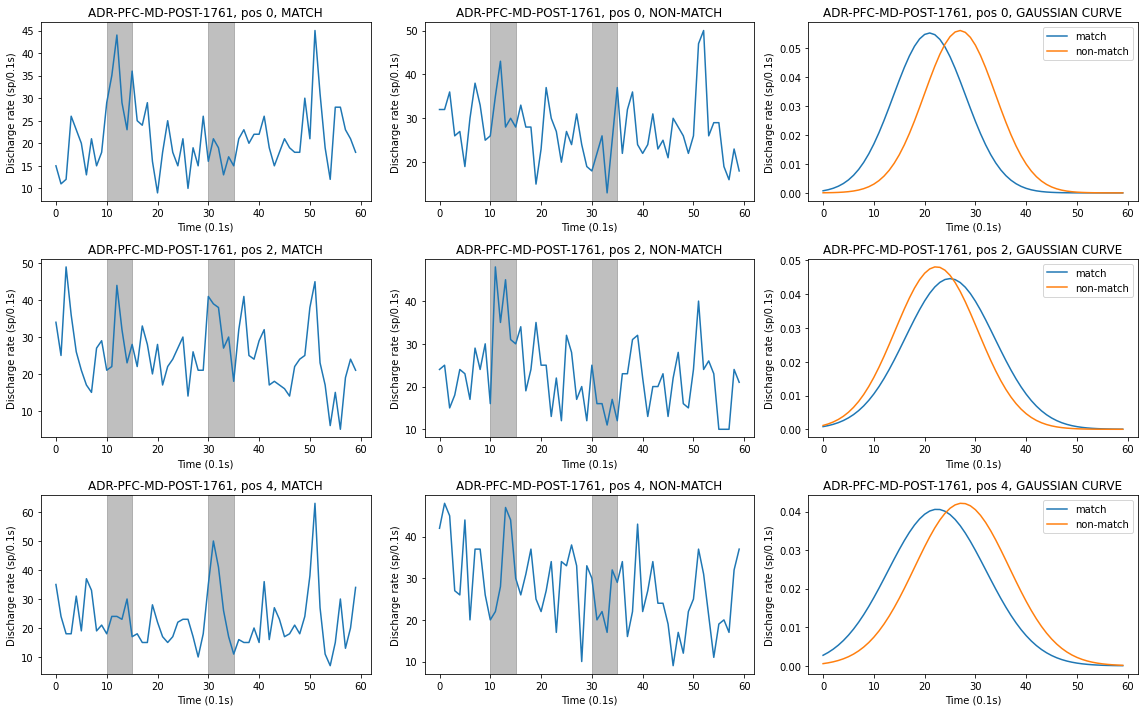

In [97]:
cell_name = "ADR-PFC-MD-POST-1761"
plotting(post_df, cell_name)

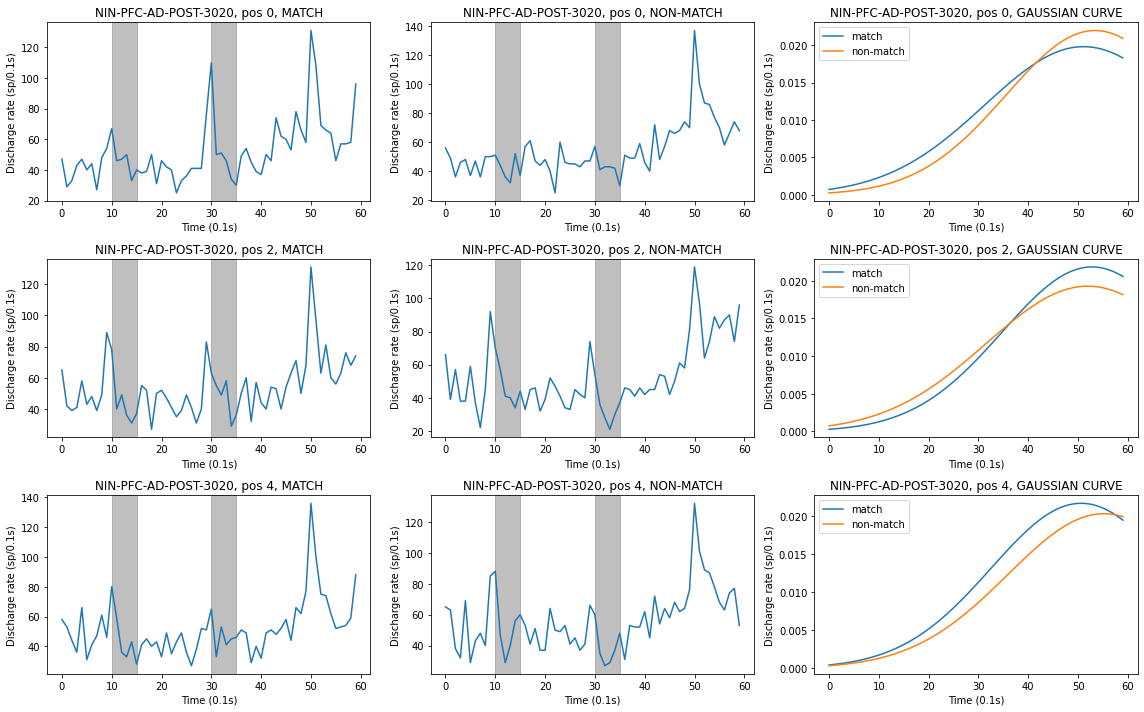

In [19]:
cell_name = "NIN-PFC-AD-POST-3020"
plotting(post_df, cell_name)

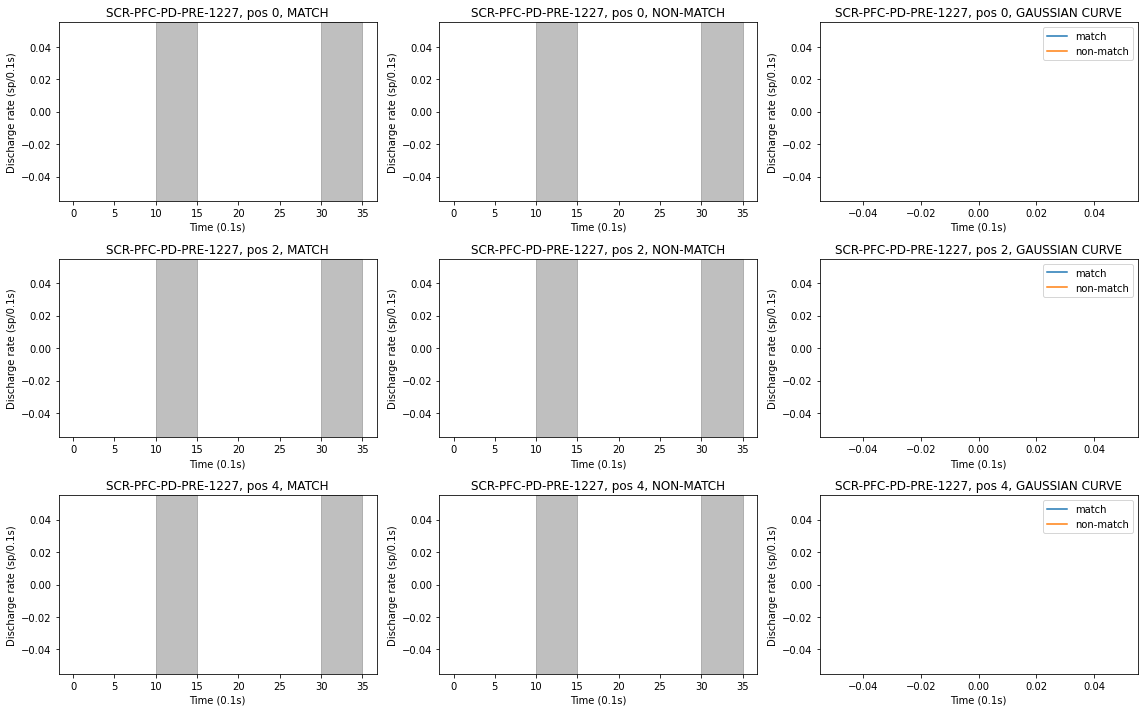

In [18]:
cell_name = "SCR-PFC-PD-PRE-1227"
plotting(post_df, cell_name)